In [1]:
import xarray as xr
import xcdat as xc
import numpy as np
import xskillscore as xs
import xesmf

Summary:
This notebook compares using cdat regridding method, and the methods supported by xcdat, for regridding a dataset without mask, precipitation (PRECT).
In the results shown in this case:
1. CDAT convervative and XCDAT conservative method shows a notable patten
2. The XCDAT results is validated with xesmf to make sure there isn't any issue in implementation.

Data for testing available from :https://web.lcrc.anl.gov/public/e3sm/zhang40/cdat-migration-fy24/test_data/


In [2]:
# Data can be found at 
f_a = '/Users/zhang40/Downloads/xcdat/GPCP_v3.2-PRECT-ANN-global_test.nc' 
f_b = '/Users/zhang40/Downloads/xcdat/GPCP_v3.2-PRECT-ANN-global_ref.nc' 
f_diff = '/Users/zhang40/Downloads/xcdat/GPCP_v3.2-PRECT-ANN-global_diff.nc' 

In [3]:
# Regridding with cdat
import cdms2

var = 'PRECT'
var1 = cdms2.open(f_a)('PRECT',squeeze=1)
var2 = cdms2.open(f_b)(var,squeeze=1)

In [4]:
var2_conserv_cdat = var2.regrid(
            var1.getGrid(),
            regridTool='esmf',
            regridMethod='conservative',
        )
var2_bilinear_cdat = var2.regrid(
            var1.getGrid(),
            regridTool='esmf',
            regridMethod='bilinear',
        )

In [5]:
var2_bilinear_cdat.data - var2_conserv_cdat.data

array([[-0.04573652, -0.04617706, -0.04555795, ..., -0.04844052,
        -0.04344141, -0.04532295],
       [ 0.02321899,  0.01856904,  0.01459555, ...,  0.02578892,
         0.02417397,  0.0249887 ],
       [ 0.01802194,  0.01595725,  0.01479241, ...,  0.01937693,
         0.01678622,  0.0164043 ],
       ...,
       [-0.00888884, -0.01317805, -0.01272738, ..., -0.00855684,
        -0.01207894, -0.00943464],
       [-0.0042327 , -0.01150799, -0.00822443, ..., -0.00877571,
        -0.00947428, -0.00396723],
       [ 0.15514237,  0.15885395,  0.16220564, ...,  0.15906054,
         0.16312206,  0.15771025]], dtype=float32)

In [6]:
# Regridding with xcdat
tas_a = xr.open_dataset(f_a)
tas_b = xr.open_dataset(f_b)

In [7]:
tas_b

<xarray.Dataset>
Dimensions:  (lon: 720, lat: 360)
Coordinates:
  * lon      (lon) float32 0.25 0.75 1.25 1.75 2.25 ... 358.2 358.8 359.2 359.8
  * lat      (lat) float32 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
Data variables:
    PRECT    (lat, lon) float32 ...

In [8]:
output_grid = tas_a.regridder.grid

tas_b_regrid_conservative_normed = tas_b.regridder.horizontal(
            var, output_grid, tool='xesmf', method='conservative_normed'
        )

tas_b_coarse_normed = tas_b_regrid_conservative_normed[var]

tas_b_regrid_bilinear = tas_b.regridder.horizontal(
            var, output_grid, tool='xesmf', method='bilinear'
        )

tas_b_coarse_bilinear = tas_b_regrid_bilinear[var]


In [9]:
# Convert cdat object to xarray
var2_conserv_cdat_xarray = tas_b_coarse_normed.copy()
var2_conserv_cdat_xarray.values = var2_conserv_cdat.data

var2_bilinear_cdat_xarray = tas_b_coarse_normed.copy()
var2_bilinear_cdat_xarray.values = var2_bilinear_cdat.data

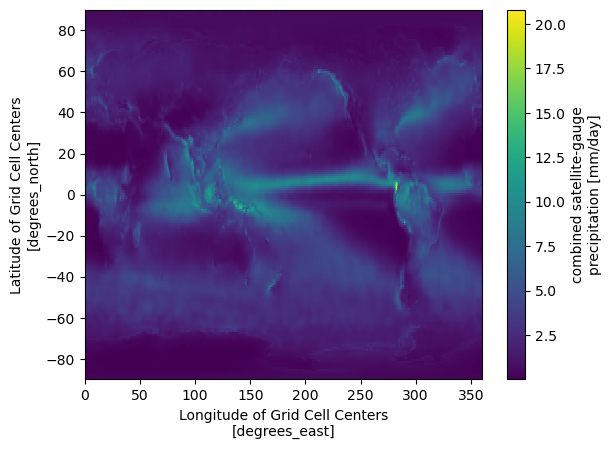

In [10]:
var2_conserv_cdat_xarray.plot()

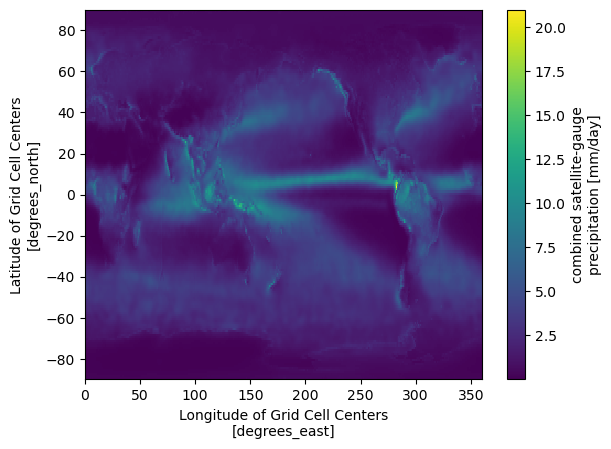

In [11]:
tas_b_coarse_normed.plot()

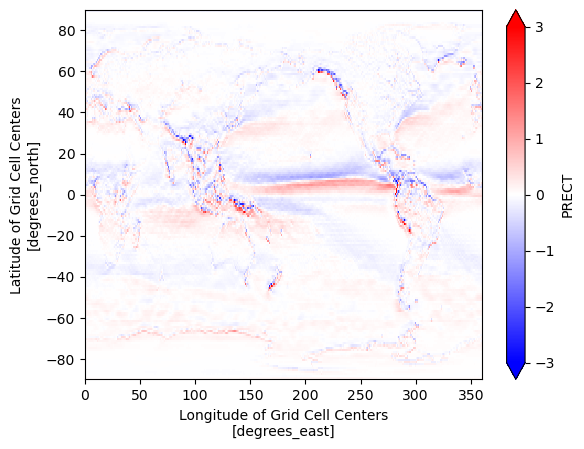

In [12]:
# Plot difference: CDAT conservative vs XCDAT conservative
(var2_conserv_cdat_xarray-tas_b_coarse_normed).plot(cmap = 'bwr', vmin = -3, vmax=3)

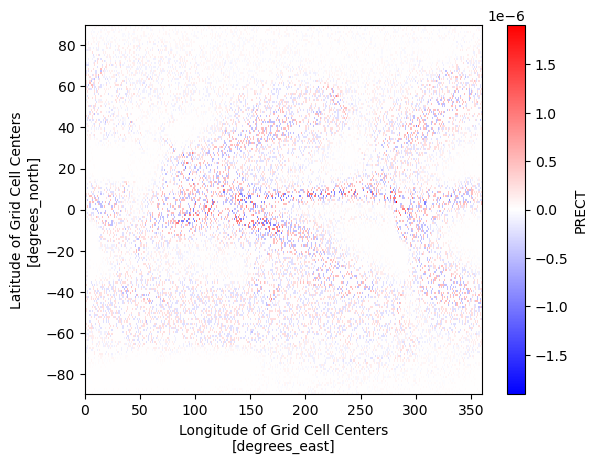

In [32]:
# Plot difference: CDAT bilinear vs XCDAT bilinear
(var2_bilinear_cdat_xarray-tas_b_coarse_bilinear).plot(cmap = 'bwr')

In [18]:
def print_stats(arr1, arr2, label1="Array 1", label2="Array 2"):
    stats = {
        "Min": (np.min(arr1), np.min(arr2)),
        "Max": (np.max(arr1), np.max(arr2)),
        "Mean": (np.mean(arr1), np.mean(arr2)),
        "Std": (np.std(arr1), np.std(arr2)),
    }
    
    print(f"{'Stat':<10} {label1:<15} {label2:<15}")
    print("-" * 40)
    for stat, values in stats.items():
        print(f"{stat:<10} {values[0]:<15.6f} {values[1]:<15.6f}")

In [19]:
print_stats(var2_conserv_cdat_xarray, tas_b_coarse_normed)

Stat       Array 1         Array 2        
----------------------------------------
Min        0.009367        0.008061       
Max        20.795750       20.991650      
Mean       2.326315        2.325912       
Std        1.928782        1.931045       


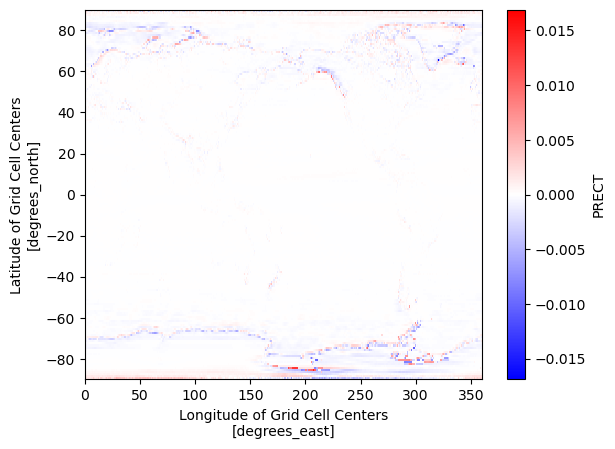

In [20]:
# Plot difference: CDAT biliner vs XCDAT conservative
(var2_bilinear_cdat_xarray-tas_b_coarse_normed).plot(cmap = 'bwr')

In [30]:
#tas_b = tas_b.drop_vars(['bounds_lat','bounds_lon'])
tas_b = tas_b.bounds.add_missing_bounds()
tas_a = tas_a.bounds.add_missing_bounds()

2025-03-17 15:48:35,641 [WARNING]: bounds.py(create_bounds:939) >> The 'lat' coordinate variable is missing a 'units' attribute. Assuming 'units' is 'degrees_north'.
2025-03-17 15:48:35,641 [WARNING]: bounds.py(create_bounds:939) >> The 'lat' coordinate variable is missing a 'units' attribute. Assuming 'units' is 'degrees_north'.


In [31]:
# Verify if rmse from xs is same as simple calculation
weights = tas_a.spatial.get_weights(["X","Y"], data_var='PRECT')
weights0 = tas_b.spatial.get_weights(["X","Y"], data_var='PRECT')

result_xr_conservative_normed = xs.rmse(tas_a['PRECT'], tas_b_coarse_normed, dim=["lat", "lon"], weights=weights, skipna=True)
#rmse_normed = np.sqrt(((tas_a['PRECT'] -tas_b_coarse_normed) ** 2).mean(skipna=True))
print('xs. rmse cons_normed', result_xr_conservative_normed.values)#, 'direct calculation (unweighted)', rmse_normed.values)
result_xr_conservative_normed = xs.rmse(tas_a['PRECT'], var2_conserv_cdat_xarray, dim=["lat", "lon"], weights=weights, skipna=True)
#rmse_normed = np.sqrt(((tas_a['PRECT'] -var2_conserv_cdat_xarray) ** 2).mean(skipna=True))
print('xs. rmse cons. cdat', result_xr_conservative_normed.values)#, 'direct calculation (unweighted)', rmse_normed.values)

print('--------------------------------')
print('area-weighted integral and mean')

print('Original',tas_b[var].weighted(weights0).sum(dim=['lat','lon']).values,tas_b[var].weighted(weights0).mean(dim=['lat','lon']).values)
print('cons. normed',tas_b_coarse_normed.weighted(weights).sum(['lat','lon']).values,tas_b_coarse_normed.weighted(weights).mean(['lat','lon']).values)
print('cons. cdat',var2_conserv_cdat_xarray.weighted(weights).sum(['lat','lon']).values,var2_conserv_cdat_xarray.weighted(weights).mean(['lat','lon']).values)

xs. rmse cons_normed 1.041638017569983
xs. rmse cons. cdat 1.0594444719946208
--------------------------------
area-weighted integral and mean
Original 2024.6234 2.811927858383278
cons. normed 2024.6147982027942 2.811964997503859
cons. cdat 2024.375384647578 2.81163247867717


/Users/zhang40/mambaforge/envs/e3sm-unified/lib/python3.10/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


In [23]:
test_grid_with_bounds = {'lon': tas_a['lon'],
                           'lat': tas_a['lat'],


                           'lon_b': np.unique(np.sort(tas_a['lon_bnds'].values.flatten())),
                           'lat_b': np.unique(np.sort(tas_a['lat_bnds'].values.flatten())),
                          }

ref_grid_with_bounds = {'lon': tas_b['lon'],
                           'lat': tas_b['lat'],

                           'lon_b': np.unique(np.sort(tas_b['lon_bnds'].values.flatten())),
                           'lat_b': np.unique(np.sort(tas_b['lat_bnds'].values.flatten())),

                          }

In [24]:
xesmf_reg = True  # False for xcdat regridding
                    # True for using xesmf_reg, which requires assigning bounds manually
na_thres = 0

In [25]:
# Adaptive regridding supported by xesmf:https://pangeo-xesmf.readthedocs.io/en/latest/notebooks/Masking.html#Adaptive-masking
# Also discussed here:https://github.com/pangeo-data/xESMF/issues/256#issuecomment-2198071089
#In case skipna is active, a given output point is set to NaN only if the ratio of missing values exceeds the threshold level set by na_thres, and else, a renormalization is conducted. 

if xesmf_reg:
    na_thres = 0    # the threshold of ratio of missing points, 0 means any nan from source will flaged as nan in target grid, yielding more nans
    regridder = xesmf.Regridder(ref_grid_with_bounds, test_grid_with_bounds, method="bilinear", periodic= True)
    tas_b_coarse_bilinear_xe = regridder(
        tas_b[var],
        #skipna=True,
        #na_thres=na_thres,  # lowering this results in more NaNs in ds_coarse
    )

    regridder = xesmf.Regridder(ref_grid_with_bounds, test_grid_with_bounds, method="conservative", periodic= True)
    tas_b_coarse_conservative_xe = regridder(
        tas_b[var],
        #skipna=True,
        #na_thres=na_thres,  # lowering this results in more NaNs in ds_coarse
    )

    regridder = xesmf.Regridder(ref_grid_with_bounds, test_grid_with_bounds, method="conservative_normed", periodic= True)
    tas_b_coarse_normed_xe = regridder(
        tas_b[var],
        #skipna=True,
        #na_thres=na_thres,  # lowering this results in more NaNs in ds_coarse
    )


In [28]:
tas_b_coarse_normed_xe.values[::-1] - tas_b_coarse_normed

<xarray.DataArray 'PRECT' (lat: 180, lon: 360)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
Coordinates:
  * lon      (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
Attributes:
    units:          mm/day
    long_name:      combined satellite-gauge precipitation
    valid_range:    [  0. 100.]
    cell_methods:   time: mean
    regrid_method:  conservative_normed